# Data Analysis

## Setup

Import required modules

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter

from tapqir.models import SpotDetection
from tapqir.utils.dataset import GlimpseDataset, CosmosDataset, load_data
from pyro import param
from torch.distributions.utils import probs_to_logits, logits_to_probs
import torch.distributions.constraints as constraints

from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve, roc_auc_score

%load_ext autoreload
%autoreload 2

## View Glimpse Images

Load glimpse files

In [2]:
path_data = "/shared/centaur/data/test/LarryCy3sigma54/"
glimpse = GlimpseDataset(path_data)
data = load_data(path_data, "test")
control = load_data(path_data, "control")

View target DNA sites

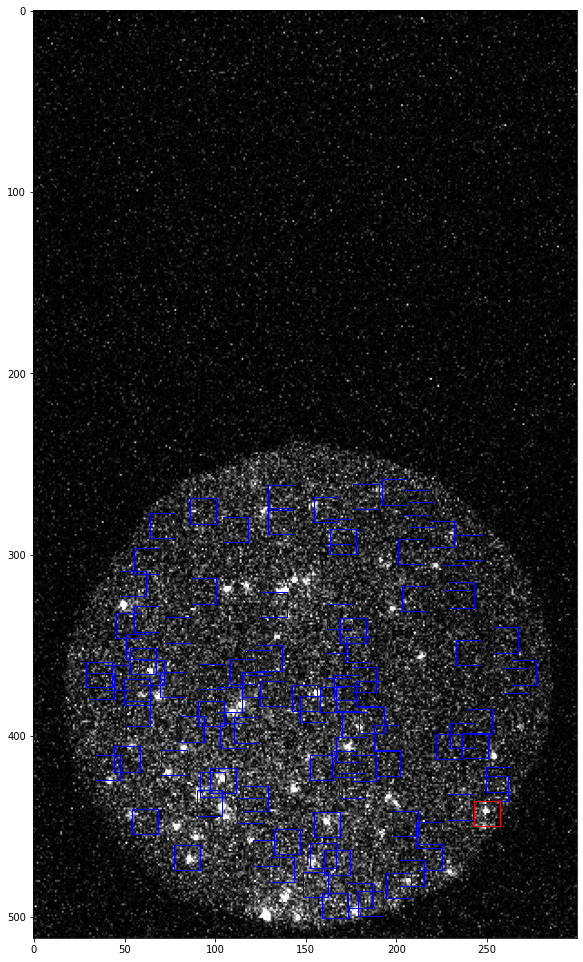

In [3]:
frame = data.drift.index[5]
plt.figure(figsize=(10, 10*glimpse.height/glimpse.width))
plt.imshow(glimpse[frame], cmap="gray", vmin=data.vmin, vmax=data.vmax)

for n in data.target.index:
    y_pos = data.target.at[n, "abs_y"] + data.drift.at[frame, "abs_dy"] - 7
    x_pos = data.target.at[n, "abs_x"] + data.drift.at[frame, "abs_dx"] - 7
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14, edgecolor="b", facecolor="none"))
    #plt.gca().text(y_pos, x_pos, str(n), fontsize=10, color="white")

aoi = data.target.index[4]  
y_pos = data.target.at[aoi, "abs_y"] + data.drift.at[frame, "abs_dy"] - 7
x_pos = data.target.at[aoi, "abs_x"] + data.drift.at[frame, "abs_dx"] - 7
plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14, edgecolor="r", facecolor="none"))
plt.show()

View non DNA sites

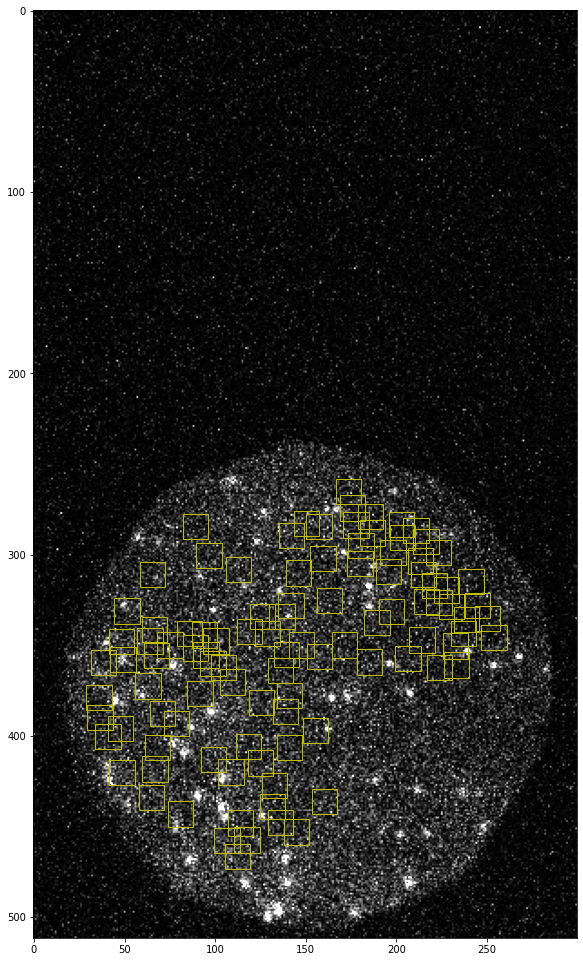

In [4]:
frame = data.drift.index[105]
plt.figure(figsize=(10, 10*glimpse.height/glimpse.width))
plt.imshow(glimpse[frame], cmap="gray", vmin=data.vmin, vmax=data.vmax)

for n in data.target.index:
    y_pos = control.target.at[n, "abs_y"] + control.drift.at[frame, "abs_dy"] - 7
    x_pos = control.target.at[n, "abs_x"] + control.drift.at[frame, "abs_dx"] - 7
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14, edgecolor="y", facecolor="none"))

plt.show()

## Load parameters

In [5]:
path_params = os.path.join(path_data, "runs/test/v1.1.5/S1/nocontrol/lr0.005/bs2")
# load global parameters
results = pd.read_csv(
    os.path.join(path_params, "global_params.csv"),
    header=None, squeeze=True, index_col=0)
# load parameters
model = SpotDetection(S=1, K=2)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)
# load spotpicker labels
labels = np.load(os.path.join(path_data, "labels.npy"))

## Analysis

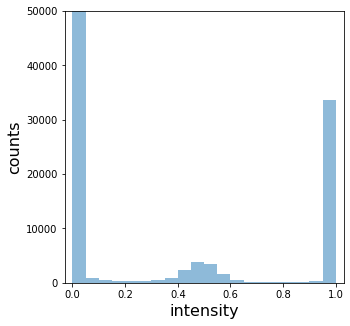

In [6]:
plt.figure(figsize=(5,5))
plt.hist(model.z_probs.flatten().numpy(),
         bins=20, alpha=0.5)
plt.ylim(0,50000)
plt.xlim(-0.03,1.03)
plt.ylabel("counts", fontsize=16)
plt.xlabel("intensity", fontsize=16)
plt.show()

### Intensity analysis

Intensity histogram (on-target spots)

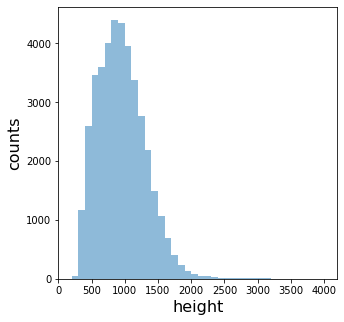

In [7]:
plt.figure(figsize=(5,5))
mask = model.z_probs > 0.5
plt.hist(param("d/h_loc").data[mask].numpy(),
         range=(0,4000), bins=40, alpha=0.5)
plt.xlim(0,)
plt.ylabel("counts", fontsize=16)
plt.xlabel("height", fontsize=16)
plt.show()

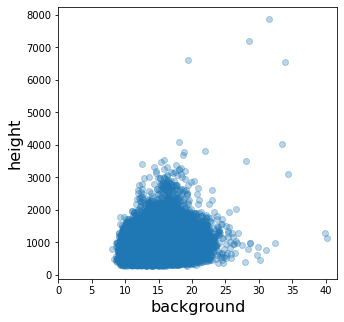

In [8]:
plt.figure(figsize=(5,5))
mask = model.z_probs > 0.5
plt.scatter(param("d/b_loc").data[mask.sum(0).bool()].numpy(), param("d/h_loc").data[mask].numpy(), alpha=0.3)
plt.xlim(0,)
plt.ylabel("height", fontsize=16)
plt.xlabel("background", fontsize=16)
plt.show()

### Binding rastergram

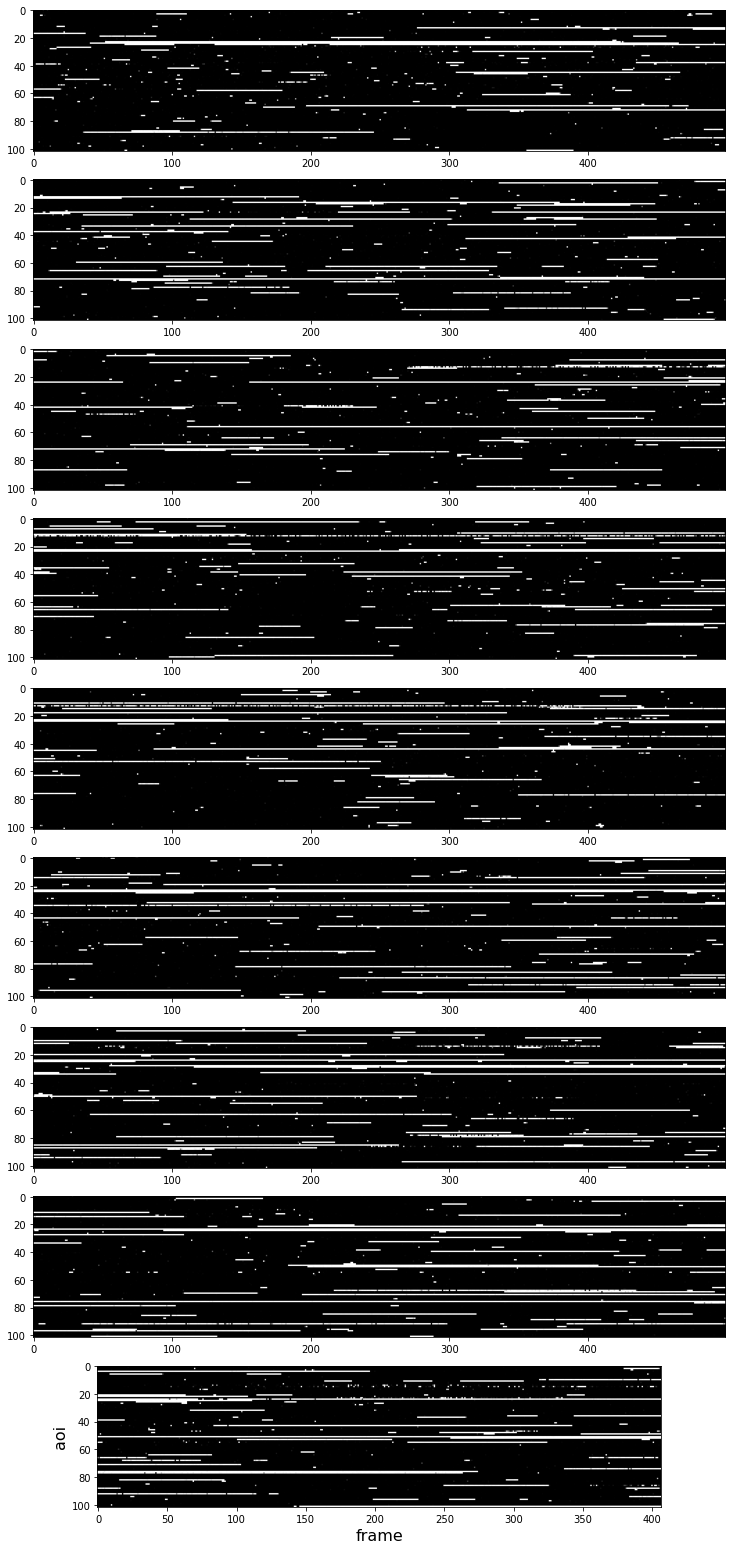

In [9]:
r = model.data.F // 500 + 1
figsize = torch.tensor([15, model.data.N * r * 15. / 500])
plt.figure(figsize=figsize)
for i in range(r):
    plt.subplot(r,1,i+1)
    plt.imshow(model.z_marginal[:, i*500:(i+1)*500], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

### Time to first binding

$$ \mathrm{ttfb} = \sum_{f=1}^{F-1} f z_{n,f} \prod_{f^\prime=0}^{f-1} (1 - z_{n,f^\prime})
    + F \prod_{f^\prime=0}^{F-1} (1 - z_{n,f^\prime}) $$

$$ \mathbb{E}[\mathrm{ttfb}] = \sum_{f=1}^{F-1} f q(z_{n,f}=1) \prod_{f^\prime=f-1}^{f-1} q(z_{n,f^\prime}=0)
    + F \prod_{f^\prime=0}^{F-1} q(z_{n,f^\prime}=0) $$

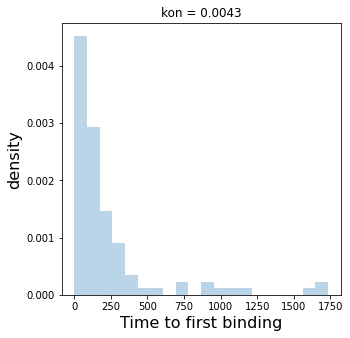

In [59]:
frames = torch.arange(1, model.data.F+1)
q1 = torch.ones(model.data.N, model.data.F)
q1[:, :-1] = model.z_marginal[:, 1:]
cumq0 = torch.cumprod(1 - model.z_marginal, dim=-1)
ttfb = (frames * q1 * cumq0).sum(-1)

plt.figure(figsize=(5,5))
plt.title("kon = {:.4f}".format(1/ttfb.mean()))
plt.hist(ttfb.numpy(), bins=20, density=True, alpha=0.3)
#plt.hist(sttfb, bins=20, density=True, alpha=0.3)
plt.xlabel("Time to first binding", fontsize=16)
plt.ylabel("density", fontsize=16)
plt.show()

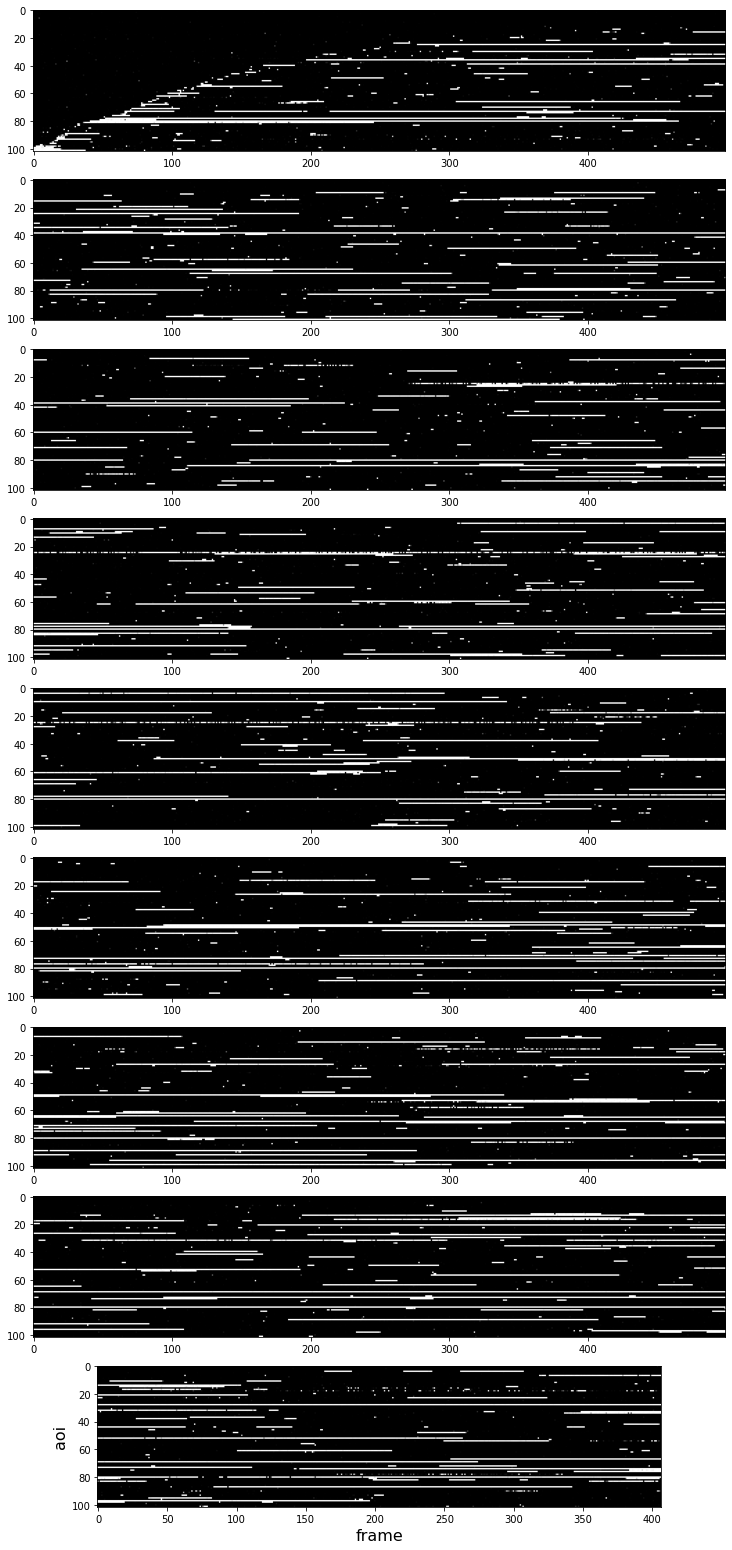

In [11]:
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=figsize)
for i in range(r):
    plt.subplot(r,1,i+1)
    plt.imshow(model.z_marginal[sdx, i*500:(i+1)*500], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

### HMM analysis


$$ A_{01} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \dfrac{(1-z_{n,f-1}) z_{n,f}}{\sum_{n^\prime=0}^{N-1} \sum_{f^\prime=1}^{F-1} (1-z_{n^\prime,f^\prime-1})} $$

$$ A_{10} = \dfrac{\sum_n^N \sum_f^F z_{n,f} (1-z_{n,f+1})}{\sum_n^N \sum_f^F z_{n,f}} $$

In [60]:
samples = dist.Bernoulli(model.z_marginal).sample((100,))

bind = (samples[..., :-1] < samples[..., 1:]).sum((-1))
dissociate = (samples[..., :-1] > samples[..., 1:]).sum(-1)

a01 = ((1 - samples[..., :-1]) * samples[..., 1:] / (1-samples[..., :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))
a10 = ((samples[..., :-1]) * (1 - samples[..., 1:]) / (samples[..., :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))

sa01 = ((1 - model.data.labels["z"][:, :-1]) * model.data.labels["z"][:, 1:] / (1-model.data.labels["z"][:, :-1]).sum((-2,-1), keepdims=True)).sum((-2,-1))
sa10 = ((model.data.labels["z"][:, :-1]) * (1 - model.data.labels["z"][:, 1:]) / (model.data.labels["z"][:, :-1]).sum((-2,-1), keepdims=True)).sum((-2,-1))

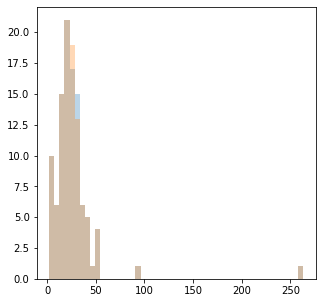

In [61]:
plt.figure(figsize=(5,5))
plt.hist(bind[0].numpy(), bins=50, alpha=0.3)
plt.hist(dissociate[0].numpy(), bins=50, alpha=0.3)
#plt.xlim(0,60)
plt.show()

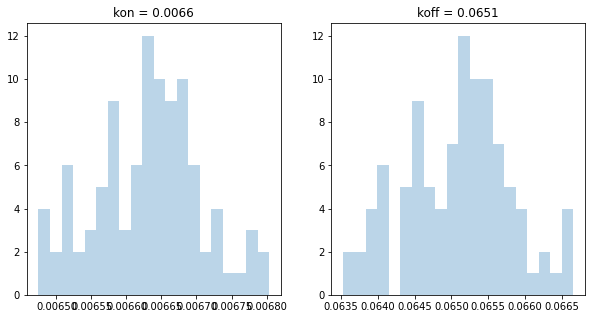

In [62]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(a01.flatten().numpy(), bins=20, alpha=0.3)
plt.title("kon = {:.4f}".format(a01.mean()))
plt.subplot(1,2,2)
plt.hist(a10.flatten().numpy(), bins=20, alpha=0.3)
plt.title("koff = {:.4f}".format(a10.mean()))
plt.show()

Let's find and remove high-frequency traces

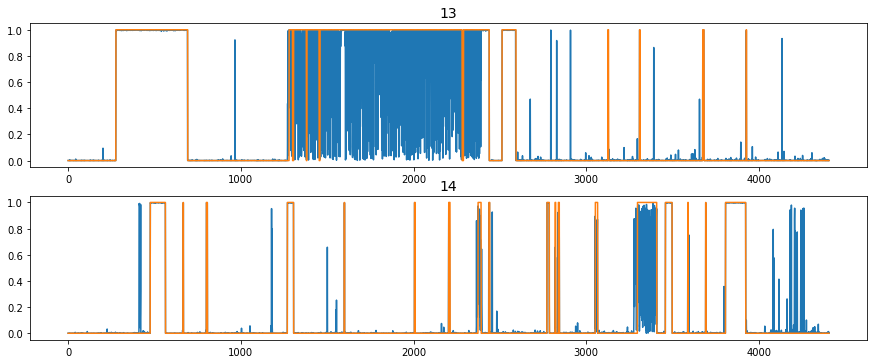

In [79]:
high_frequency = torch.nonzero(bind[0] > 60).squeeze()
r = len(high_frequency) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(high_frequency):
    plt.subplot(r,1,i+1)
    plt.title(n.item(), fontsize=14)
    plt.plot(model.z_marginal[n])
    plt.plot(model.data.labels["z"][n])
plt.show()

In [80]:
low_frequency = torch.nonzero(bind[0] <= 60).squeeze()
a01 = ((1 - samples[:, low_frequency, :-1]) * samples[:, low_frequency, 1:] / (1-samples[:, low_frequency, :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))
a10 = ((samples[:, low_frequency, :-1]) * (1 - samples[:, low_frequency, 1:]) / (samples[:, low_frequency, :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))

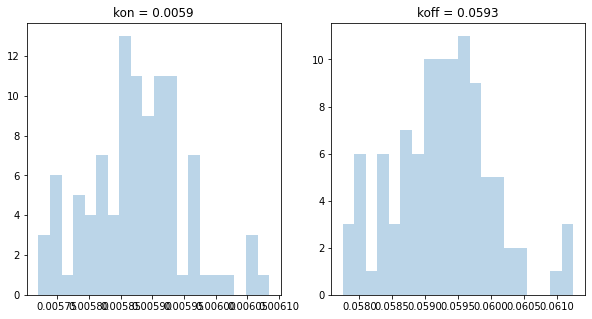

In [81]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(a01.flatten().numpy(), bins=20, alpha=0.3)
plt.title("kon = {:.4f}".format(a01.mean()))
plt.subplot(1,2,2)
plt.hist(a10.flatten().numpy(), bins=20, alpha=0.3)
plt.title("koff = {:.4f}".format(a10.mean()))
plt.show()

Now let's see how real data kinetics compares to the simulated kinetics from the best fit

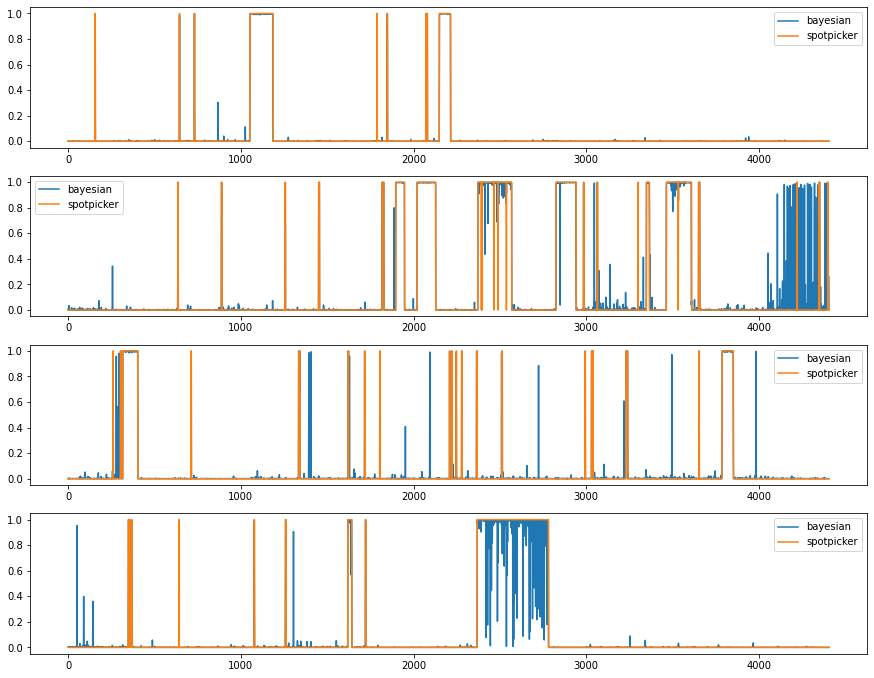

In [82]:
# look at 5, 15, 30, 35
examples = [5, 15, 30, 35]
r = len(examples) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(examples):
    plt.subplot(r,1,i+1)
    plt.plot(model.z_marginal[n], label="bayesian")
    plt.plot(model.data.labels["z"][n], label="spotpicker")
    plt.legend()
plt.show()

### Simulated trace

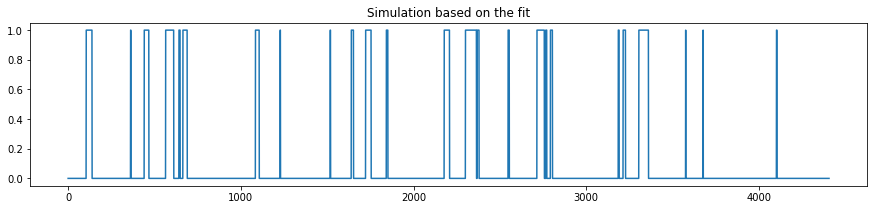

In [86]:
A = torch.tensor([[1-a01.mean(), a01.mean()], [a10.mean(), 1-a10.mean()]])

x = torch.zeros(model.data.F)
for i in range(1,model.data.F):
    x[i] = dist.Bernoulli(A[x[i-1].long()][1]).sample().item()

plt.figure(figsize=(15,3))
plt.title("Simulation based on the fit")
plt.plot(x)
plt.show()

### Spotpicker sorted rastergram

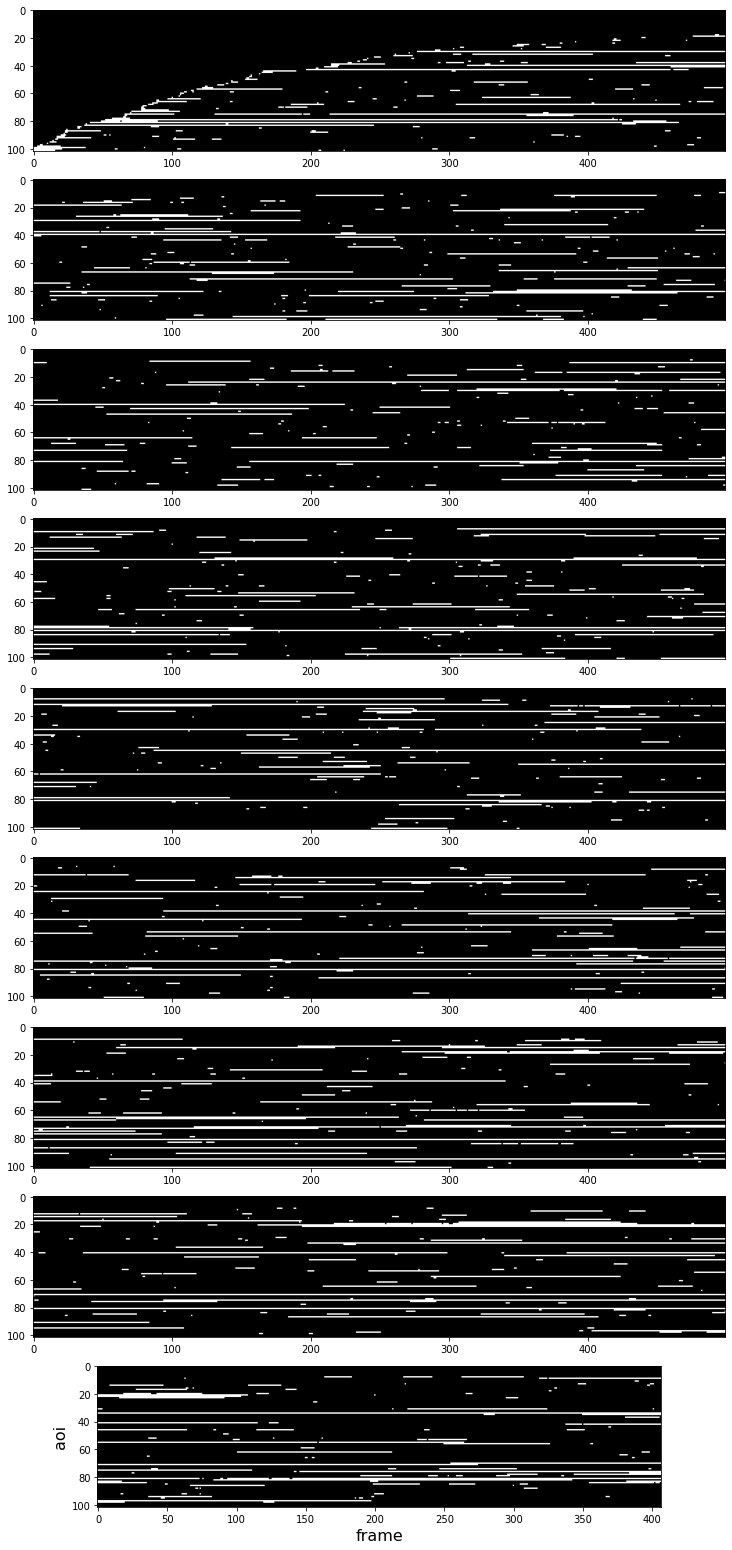

In [88]:
frames = np.arange(1, model.data.F+1)
q1 = np.ones((model.data.N, model.data.F))
q1[:, :-1] = model.data.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.data.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)
sdx = np.flip(np.argsort(sttfb))

r = model.data.F // 500 + 1
figsize = torch.tensor([15, model.data.N * r * 15. / 500])
plt.figure(figsize=figsize)
for i in range(r):
    plt.subplot(r,1,i+1)
    plt.imshow(model.data.labels["z"][sdx, i*500:(i+1)*500], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

## Appendix

$$ p(\mathbf{z}) = \prod_{n=0}^{N-1} p(z_{n,0}|\pi) \prod_{f=1}^{F-1} p(z_{n,f}|z_{n,f-1}, A) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( \log p(z_{n,0}|\pi) + \sum_{f=1}^{F-1} \log p(z_{n,f}|z_{n,f-1}, A_{01}, A_{10}) \right ) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( (1-z_{n,0}) \log (1-\pi) + z_{n,0} \log \pi +
    \sum_{f=1}^{F-1} \left (
        (1 - z_{n,f-1}) (1 - z_{n,f}) \log (1 - \frac{A_{01}}{2})
        + (1-z_{n,f-1}) z_{n,f} \log \frac{A_{01}}{2}
        + z_{n,f-1} (1 - z_{n,f}) \log \frac{1+A_{10}}{2}
        + z_{n,f-1} z_{n,f} \log (1 - A_{10}) \right ) \right ) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( (1-z_{n,0}) \log (1-\pi) + z_{n,0} \log \pi +
    \sum_{f=1}^{F-1} \left (
        (1 - z_{n,f-1}) (1 - z_{n,f}) \log (1 - A_{01})
        + (1-z_{n,f-1}) z_{n,f} \log A_{01}
        + z_{n,f-1} (1 - z_{n,f}) \log A_{10}
        + z_{n,f-1} z_{n,f} \log (1 - A_{10}) \right ) \right ) $$

$$ \dfrac{\partial \log p(\mathbf{z})}{\partial \pi}
 = \sum_{n=0}^{N-1} \left ( -\dfrac{1-z_{n,0}}{1-\pi} + \dfrac{z_{n,0}}{\pi} \right ) = 0 $$
 
$$ \sum_{n=0}^{N-1} \left ( \dfrac{(1-\pi) z_{n,0} - \pi (1-z_{n,0})}{\pi (1-\pi)} \right ) = 0 $$

$$ \dfrac{\partial \log p(\mathbf{z})}{\partial A_{01}}
 = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \left (
     \dfrac{-(1-z_{n,f-1})(1-z_{n,f})}{1-A_{01}}
     + \dfrac{(1-z_{n,f-1})z_{n,f}}{A_{01}} \right ) = 0 $$

$$ \sum_{n=0}^{N-1} \left ( z_{n,0} - \pi \right ) = 0 $$

$$ \pi = \dfrac{1}{N} \sum_{n=0}^{N-1} z_{n,0} $$

$$ \mathbb{E}_{q(\mathbf{z})} \left [ \pi \right ] = \dfrac{1}{N} \sum_{n=0}^{N-1} q(z_{n,0}=1) $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \left ( (1-A_{01}) (1-z_{n,f-1})z_{n,f} - A_{01} (1-z_{n,f-1})(1-z_{n,f}) \right ) = 0 $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) z_{n,f} - \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) A_{01} = 0 $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) z_{n,f} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) A_{01} $$

$$ A_{01} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \dfrac{(1-z_{n,f-1}) z_{n,f}}{\sum_{n^\prime=0}^{N-1} \sum_{f^\prime=1}^{F-1} (1-z_{n^\prime,f^\prime-1})} $$

$$ A_{10} = \dfrac{\sum_n^N \sum_f^F z_{n,f} (1-z_{n,f+1})}{\sum_n^N \sum_f^F z_{n,f}} $$

$$ \mathbb{E}_{q(\mathbf{z})} \left [ A_{01} \right ]
    = \sum_\mathbf{z} \sum_n^N \sum_f^F \dfrac{(1-z_{n,f}) z_{n,f+1}}{\sum_{n^\prime}^N \sum_{f^\prime}^F (1-z_{n^\prime,f^\prime})} q(\mathbf{z}) $$

$$  = \sum_n^N \sum_f^F q(z_{n,f}=0) q(z_{n,f+1}=1) \sum_{\mathbf{z} \backslash z_{n,f},z_{n,f+1}}
    \dfrac{1}{1 + 0 + \sum_{n^\prime}^N \sum_{f^\prime}^F (1-z_{n^\prime,f^\prime})} q(\mathbf{z}) $$